In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd
from westgate.flaml_model import *
import pandas as pd
from westgate.combochart import combo_chart
import argparse
from colored import Fore, Back, Style
from sklearn.ensemble._stacking import StackingClassifier

In [20]:
default_model = UWModel(experiment_id='default_1.0')

In [2]:
accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_12128\3568183418.py:1: DtypeWarning: Columns (741) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')


In [3]:
accepted_df['employer_income_frequency'].value_counts()

employer_income_frequency
BiWeekly     6553
Weekly       1365
BiMonthly    1124
Unknown       545
Monthly        48
Name: count, dtype: int64

In [22]:
len(accepted_df)

10098

In [23]:
accepted_df['request_month'] = accepted_df['request_date'].str[5:7].astype(int)
accepted_df['validation_flag'] = accepted_df['request_month'] == 11
accepted_df['test_flag'] = accepted_df['request_month'] == 12
accepted_df['weight'] = accepted_df['request_month'] / 12.0

In [24]:
accepted_df['profit'] = accepted_df['total_paid'] - accepted_df['principal']

In [25]:
accepted_df[default_model.target] = np.where(accepted_df['profit'] < 50, 1, 0)

In [26]:
accepted_df[default_model.target].value_counts(normalize=True)

status
0    0.700832
1    0.299168
Name: proportion, dtype: float64

In [27]:
filtered_df = default_model.filter_df(accepted_df)

In [28]:
len(filtered_df)

9507

In [29]:
filtered_df[default_model.target].value_counts(normalize=True)

status
0    0.703376
1    0.296624
Name: proportion, dtype: float64

In [30]:
#not used
#rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=0)

In [34]:
# here X_teste is December

X_train, X_test, y_train, y_test, extra = default_model.split_data(filtered_df, 
                                                            split_criteria='test_flag',
                                                            extra_cols=['weight', 'validation_flag', 'request_month'])

X_train, X_test, y_train, y_test, extra = r

X_train, X_test = default_model.feature_engineer(X_train, y_train, X_test, y_test)

#TODO: deal with na values in X_train/X_test if any
#non_na_idx = X['age'].notna()

#X = X[non_na_idx]

#if y is not None:
    #y = y[non_na_idx]



In [35]:
extra.keys()

dict_keys(['train_weight', 'test_weight', 'train_validation_flag', 'test_validation_flag', 'train_request_month', 'test_request_month', 'train_profit', 'test_profit', 'train_Id', 'test_Id', 'train_principal', 'test_principal', 'train_total_paid', 'test_total_paid', 'train_request_date', 'test_request_date', 'train_dob', 'test_dob'])

In [36]:
len(X_train)

8455

In [37]:
# here X_val is November

X_val, y_val = X_train.loc[extra['train_validation_flag']], y_train.loc[extra['train_validation_flag']]
X_train, y_train = X_train.loc[~extra['train_validation_flag']], y_train.loc[~extra['train_validation_flag']]

In [38]:
len(X_train) + len(X_val) + len(X_test) == len(filtered_df)

True

In [39]:
weight_train = extra['train_weight'].loc[~extra['train_validation_flag']]
weight_val = extra['train_weight'].loc[extra['train_validation_flag']]
weight_test = extra['test_weight']

In [40]:
len(weight_train), len(weight_val), len(weight_test)

(7501, 954, 1052)

In [41]:
len(X_train), len(X_val), len(X_test)

(7501, 954, 1052)

X_train shape: (7501, 26)
X_test shape: (1052, 26)



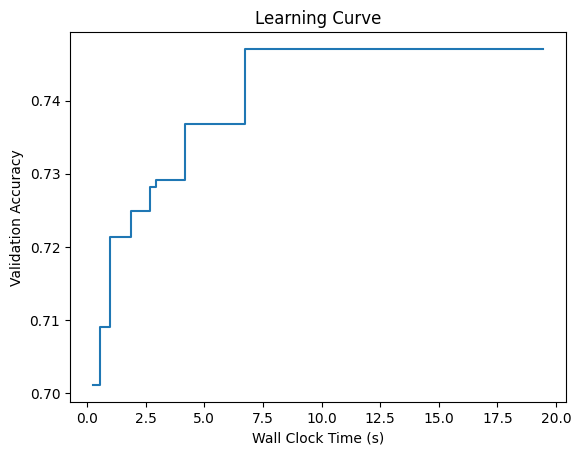

Actual Default[TEST]:
297 (28.2%)
Predicted Default[TEST]:
106 (10.1%)

y_pred_proba distribution:
(0.135, 0.184]    259
(0.184, 0.232]    247
(0.232, 0.28]     169
(0.28, 0.328]     129
(0.328, 0.376]     86
(0.376, 0.424]     51
(0.424, 0.472]     43
(0.472, 0.52]      30
(0.52, 0.568]      28
(0.568, 0.616]     10
Name: count, dtype: int64

Best validation loss: -0.2529479265590374


              precision    recall  f1-score   support

           0       0.76      0.95      0.84       755
           1       0.63      0.23      0.33       297

    accuracy                           0.74      1052
   macro avg       0.69      0.59      0.59      1052
weighted avg       0.72      0.74      0.70      1052

Normalized confusion matrix:
[[0.94834437 0.05165563]
 [0.77441077 0.22558923]]


Profitability stats
----
Predicted profit [TEST]: $206325.00
Actual profit [TEST]: $203798.00
Anti-profit [TEST]: $-2527.00
Anti-profit per loan [TEST]: $-2.00
----


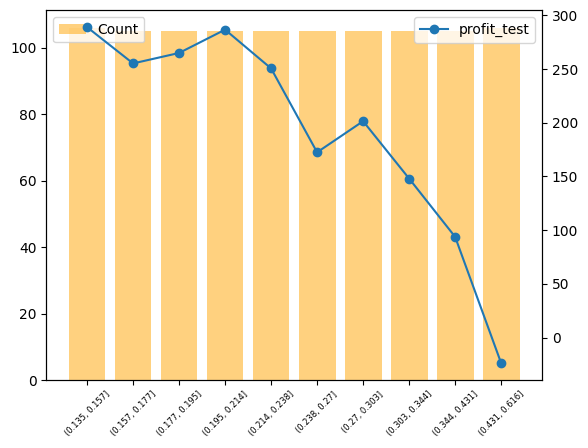

In [42]:
def p90_accuracy_metric(X_val, y_val, estimator, labels,
                X_train, y_train, weight_val=None, weight_train=None,
                *args):
    y_probas = estimator.predict_proba(X_val)[:, 1]
    df = pd.DataFrame({'proba': y_probas, 'y_val': y_val})
    perc90 = np.percentile(y_probas, 90)
    perc10 = np.percentile(y_probas, 10)
    delta = df.loc[df['proba'] >= perc90]['y_val'].sum() - df.loc[df['proba'] <= perc10]['y_val'].sum()
    return -delta, {}
        
config = {
    #"ensemble": True,
    #"estimator_list": ['xgb_limitdepth'],
    "estimator_list": ['xgboost'],
    "metric": "roc_auc",
    #"metric": p90_accuracy_metric,
    "eval_method": 'holdout',
    'X_val': X_val,
    'y_val': y_val,
    'sample_weight': weight_train,
    'sample_weight_val': weight_val
}

y_pred_proba, y_pred, extra = default_model.fit(
        X_train, X_test, y_train, y_test, extra,
        time_budget=20, 
        automl_config=config,
        show_plots=True,
        percentile=90
)

In [43]:
default_model.save()

In [44]:
len(default_model.features)

26

In [45]:
print(default_model.features)

['average_closing_balance_day_after_employer_income', 'average_closing_balance_day_of_employer_income', 'average_closing_balance_day_of_income', 'average_monthly_micro_loan_payments_complex', 'average_monthly_utility_payments_complex', 'balance_90_days_ago', 'balance_current', 'balance_min', 'count_days_negative_balance_90_days', 'count_distinct_micro_lenders', 'count_loan_payments_current_month', 'count_loan_payments_previous_month', 'count_nsf_30_days', 'employer_income_frequency', 'sum_employer_income_2_months_ago', 'sum_employer_income_current_month', 'sum_employer_income_previous_month', 'sum_non_employer_income', 'sum_non_employer_income_2_months_ago', 'sum_non_employer_income_current_month', 'sum_non_employer_income_previous_month', 'telecom_payments_average', 'other_loan_payments_average', 'utility_payments_average', 'gender', 'age']


In [46]:
X2022 = pd.concat([X_train, X_val, X_test])

In [47]:
y2022 = pd.concat([y_train, y_val, y_test])

In [48]:
weight2022 = pd.concat([weight_train, weight_val, weight_test])

In [49]:
default_model.automl.retrain_from_log(
    'log_default_1.0.log',
    X2022,
    y2022,
    train_best=True,
    train_full=True,
    sample_weight=weight2022,
    time_budget=20
)

[flaml.automl.logger: 03-23 08:28:56] {804} INFO - log file name log_default_1.0.log
[flaml.automl.logger: 03-23 08:28:56] {857} INFO - estimator = xgboost, config = {'n_estimators': 42, 'max_leaves': 103, 'min_child_weight': 0.059680146826664886, 'learning_rate': 0.03027862259035647, 'subsample': 0.763787915762039, 'colsample_bylevel': 0.5493443205226076, 'colsample_bytree': 0.7196188089311553, 'reg_alpha': 0.05227653182206384, 'reg_lambda': 2.564998901900601}, #training instances = 9507
[flaml.automl.logger: 03-23 08:28:58] {890} INFO - retrain from log succeeded


19.464924812316895

Saving / loading the model

In [50]:
default_model.save()

In [51]:
default_model_loaded = load_model('default_1.0')

In [52]:
preds2022 = default_model.predict_proba(X2022, filter=False, engineer=False)

In [53]:
p90_2022 = np.percentile(preds2022['pred_proba'], 90)
p90_2022

0.4266939163208007

# Predictions for Jan'23

In [42]:
data2023_df = pd.read_csv('../data/janToNov2023Loansv2.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_3504\4126847242.py:1: DtypeWarning: Columns (387) have mixed types. Specify dtype option on import or set low_memory=False.
  data2023_df = pd.read_csv('../data/janToNov2023Loansv2.csv', encoding='latin')


In [43]:
len(data2023_df)

9499

In [44]:
jan23_df = data2023_df.loc[data2023_df['request_date'].str[:7]=='2023-01']

In [45]:
len(jan23_df)

1045

In [46]:
jan23_df.drop_duplicates(inplace=True)

In [47]:
len(jan23_df)

1040

In [58]:
jan23_df.set_index('loanId', inplace=True)

In [59]:
jan23_df.head()

,dob,gender,request_date,account_age_days,active_days_trend,auto_loan_payment_frequency,average_closing_balance_day_after_employer_income,average_closing_balance_day_after_government_income,average_closing_balance_day_after_income,average_closing_balance_day_of_employer_income,...,sum_wsib_income,student_loan_payments_frequency,telecom_payments_frequency,telecom_payments_average,other_loan_payments_frequency,other_loan_payments_average,utility_payments_frequency,utility_payments_average,average_monthly_insurance_income_complex,MostRecentTransactionDate
loanId,,,,,,,,,,,,,,,,,,,,,
3970620,1991-09-15,Female,2023-01-19,366.0,1.03,Monthly,364.90,85.89,297.83,329.04,...,0.0,Unknown,Unknown,143.38,BiWeekly,293.26,NONE_DETECTED,0.00,7.27,05/25/2023
3986502,1991-11-07,Female,2023-01-31,365.0,1.02,NONE_DETECTED,381.74,269.92,276.69,411.25,...,0.0,NONE_DETECTED,Unknown,130.27,NONE_DETECTED,0.00,NONE_DETECTED,0.00,0.00,06/19/2023
3813879,1989-08-16,Male,2023-01-02,366.0,1.06,Weekly,996.93,-55.76,835.17,1153.10,...,0.0,NONE_DETECTED,NONE_DETECTED,0.00,Weekly,83.37,NONE_DETECTED,0.00,0.00,08/29/2023
3814985,2004-02-04,Male,2023-01-03,365.0,0.74,NONE_DETECTED,1178.11,1.26,1114.36,1249.69,...,0.0,NONE_DETECTED,Monthly,40.40,NONE_DETECTED,0.00,Unknown,76.93,0.40,04/21/2023
3813995,1992-08-21,Male,2023-01-02,366.0,1.08,NONE_DETECTED,522.96,170.62,429.96,525.33,...,0.0,NONE_DETECTED,Unknown,163.80,BiWeekly,279.30,Unknown,157.44,1.08,08/07/2023


In [48]:
loans23_df = pd.read_csv('../data/loans_branch-if-jan2023.csv')

In [49]:
loans23_df['profit'] = loans23_df['Paid Amount'] - loans23_df['Principal Amount']

In [50]:
loans23_df.set_index('Loan Id', inplace=True)

In [55]:
len(loans23_df)

31510

In [56]:
loans23_df.sort_index().head()

,Loan #,Loan Duration,Maturity Date,First Name,Last Name,Full Name,Released Date,Principal Amount,Disbursed By,Paid Amount,...,Total Interest Paid,Total Penalty Balance,Total Penalty Paid,Pending Due,Pending Fees Due,Pending Interest Due,Pending Penalty Due,Pending Principal Due,Balance Amount,profit
Loan Id,,,,,,,,,,,,,,,,,,,,,
2545807,IF10000083,3 Months,02/24/2022,Brian,Robert Wason,Brian Robert Wason,12/02/2021,300.0,Cash,587.58,...,17.58,0.0,0.0,0.00,NaN,NaN,NaN,NaN,0.00,287.58
2545954,IF10000085,3 Months,02/18/2022,Ashley,Sarah Pulker,Ashley Sarah Pulker,12/02/2021,300.0,Online Transfer,391.72,...,11.72,110.0,0.0,305.86,90.0,5.86,110.0,100.0,305.86,91.72
2545977,IF10000086,2 Months,01/31/2022,Anpalagan,Dilajini,Anpalagan Dilajini,12/02/2021,200.0,Cash,379.74,...,7.74,0.0,0.0,0.00,90.0,5.86,110.0,100.0,0.00,179.74
2545990,IF10000087,3 Months,02/24/2022,Kenneth,Payne,Kenneth Payne,12/02/2021,350.0,Cash,880.51,...,20.51,0.0,210.0,0.00,90.0,5.86,110.0,100.0,0.00,530.51
2546124,IF10000091,3 Months,02/24/2022,Dawn Eleanor,Bailey,Dawn Eleanor Bailey,12/02/2021,300.0,Cash,587.58,...,17.58,0.0,0.0,0.00,90.0,5.86,110.0,100.0,0.00,287.58


In [60]:
jan23_ex_df = pd.merge(jan23_df, loans23_df, left_index=True, right_index=True, validate='one_to_one')

In [61]:
len(jan23_ex_df)

1040

In [62]:
jan23_ex_df['pred_proba'] = default_model.predict_proba(jan23_ex_df)['pred_proba']

In [63]:
predicted_defaults_df = jan23_ex_df.loc[jan23_ex_df['pred_proba'] >= p90_2022]

In [64]:
len(predicted_defaults_df), len(jan23_ex_df), len(predicted_defaults_df) / len(jan23_ex_df) 

(74, 1040, 0.07115384615384615)

In [65]:
profit_jan23 = predicted_defaults_df['profit'].sum() / len(predicted_defaults_df)
profit_jan23

-16.31202702702702

# Predictions for all 2022 + jan'23

In [66]:
request_month = pd.concat([extra['train_request_month'], extra['test_request_month']])
profits = pd.concat([extra['train_profit'], extra['test_profit']])

In [67]:
res_list = []

for month in range(1, 13):
    X_month = X2022.loc[request_month == month]
    profits_month = profits.loc[request_month == month]
    preds_df = default_model.predict_proba(X_month, filter=False, engineer=False)
    preds_df['profit'] = profits_month
    predicted_defaults = preds_df.loc[preds_df['pred_proba'] >= p90_2022]
    res_list.append({'month': '2022-' + (str(month) if month >= 10 else '0' + str(month)), 
                    'anti-profit per loan': round(predicted_defaults['profit'].sum() / len(predicted_defaults))})

profits_month = jan23_ex_df['profit']
preds_df = default_model.predict_proba(jan23_ex_df)
preds_df['profit'] = profits_month
predicted_defaults = preds_df.loc[preds_df['pred_proba'] >= p90_2022]
res_list.append({'month': '2023-01', 
                'anti-profit per loan': round(predicted_defaults['profit'].sum() / len(predicted_defaults))})

In [68]:
pd.DataFrame.from_records(res_list)

,month,anti-profit per loan
0,2022-01,-89
1,2022-02,-33
2,2022-03,42
3,2022-04,36
4,2022-05,53
5,2022-06,42
6,2022-07,13
7,2022-08,12
8,2022-09,30
9,2022-10,10


In [236]:
pd.DataFrame.from_records(res_list)['anti-profit per loan'].mean()

33.38461538461539